**Exercise 8.11**  Exhibit 6.31 on page 139, suggested specifying either an AR(1) or possibly an AR(4) model for the difference of the logarithms of the oil price series. (The filename is `oil.price`).

**(a)** Estimate both of these models using maximum likelihood and compare the results using the diagnostic tests considered in this chapter.

**(b)** Exhibit 6.32 on page 140, suggested specifying an MA(1) model for the difference of the logs. Estimate this model by maximum likelihood and perform the diagnostic tests considered in this chapter.

**(c)** Which of the three models AR(1), AR(4), or MA(1) would you prefer given the results of parts (a) and (b)?

**Solution**.

In [1]:
require(ggplot2)
require(latex2exp)
require(tseries)

Loading required package: ggplot2

Loading required package: latex2exp

Loading required package: tseries

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



In [2]:
plot_acf_with_bounds <- function(acf, lower, upper, title='ACF') {
    max_k = length(acf)
    k = seq(1, max_k)
    
    options(repr.plot.width=12, repr.plot.height=4)
    p = ggplot() + geom_ribbon(aes(x=k, ymin=lower, ymax=upper), fill='blue', alpha=0.1) +
        geom_point(aes(x=k, y=acf), color='blue')
    for (i in 1:max_k) {
        p = p + geom_line(aes_string(x=k[i], y=c(0, acf[i])), color='blue')
    }
    p + geom_line(aes(x=k, y=0), color='blue', linetype='dashed') +
        xlab('Lag') + ylab(TeX('$\\rho_k$')) +
        ggtitle(title) +
        theme_bw() + theme(text = element_text(size=16), plot.title = element_text(hjust = 0.5))
}

plot_residuals_acf <- function(resid, title, nlags=15) {
    r = acf(resid, lag.max=nlags, plot=F)$acf[-1]
    se = 1 / sqrt(length(resid))
    plot_acf_with_bounds(r, - 2 * se, + 2*se, title=title)
}

ljung.box.test <- function(r, n, k_ar=0, k_ma=0) {
    nlags = length(r)
    denominators = (n-1):(n-nlags)
    Qstar = n * (n-2) * sum(r**2 / denominators)
    df = nlags - k_ar - k_ma
    p_value = 1 - pchisq(Qstar, df=df)
    
    list('X-squared'=Qstar, df=df, 'p-value'=p_value)
}

In [3]:
Y <- read.csv('../data/oil.price.dat')[['oil.price']]
Y <- diff(log(Y))

In [4]:
model.ar1 = arima(Y, order=c(1,0,0), method='ML')
print(model.ar1)


Call:
arima(x = Y, order = c(1, 0, 0), method = "ML")

Coefficients:
         ar1  intercept
      0.2337     0.0040
s.e.  0.0661     0.0069

sigma^2 estimated as 0.006778:  log likelihood = 258.72,  aic = -511.43


In [5]:
model.ar4 = arima(Y, order=c(4,0,0), method='ML')
print(model.ar4)


Call:
arima(x = Y, order = c(4, 0, 0), method = "ML")

Coefficients:
         ar1      ar2     ar3      ar4  intercept
      0.2638  -0.1583  0.0203  -0.1008     0.0045
s.e.  0.0669   0.0691  0.0692   0.0681     0.0054

sigma^2 estimated as 0.006584:  log likelihood = 262.16,  aic = -512.32


AR(4) presents a lower AIC, but the coefficients for  𝜙3  and  𝜙4  are not significant in the AR(4) model. Let's try an AR(2) model:

In [6]:
model.ar2 = arima(Y, order=c(2,0,0), method='ML')
print(model.ar2)


Call:
arima(x = Y, order = c(2, 0, 0), method = "ML")

Coefficients:
         ar1      ar2  intercept
      0.2603  -0.1470     0.0043
s.e.  0.0666   0.0674     0.0059

sigma^2 estimated as 0.006645:  log likelihood = 261.07,  aic = -514.14


Let's also look at the MA(1) model:

In [7]:
model.ma1 = arima(Y, order=c(0,0,1), method='ML')
print(model.ma1)


Call:
arima(x = Y, order = c(0, 0, 1), method = "ML")

Coefficients:
         ma1  intercept
      0.2939     0.0041
s.e.  0.0696     0.0068

sigma^2 estimated as 0.006679:  log likelihood = 260.47,  aic = -514.94


Coefficients are also significant, and this model presents the smallest AIC.

Let's look at the residuals ACF for each model:

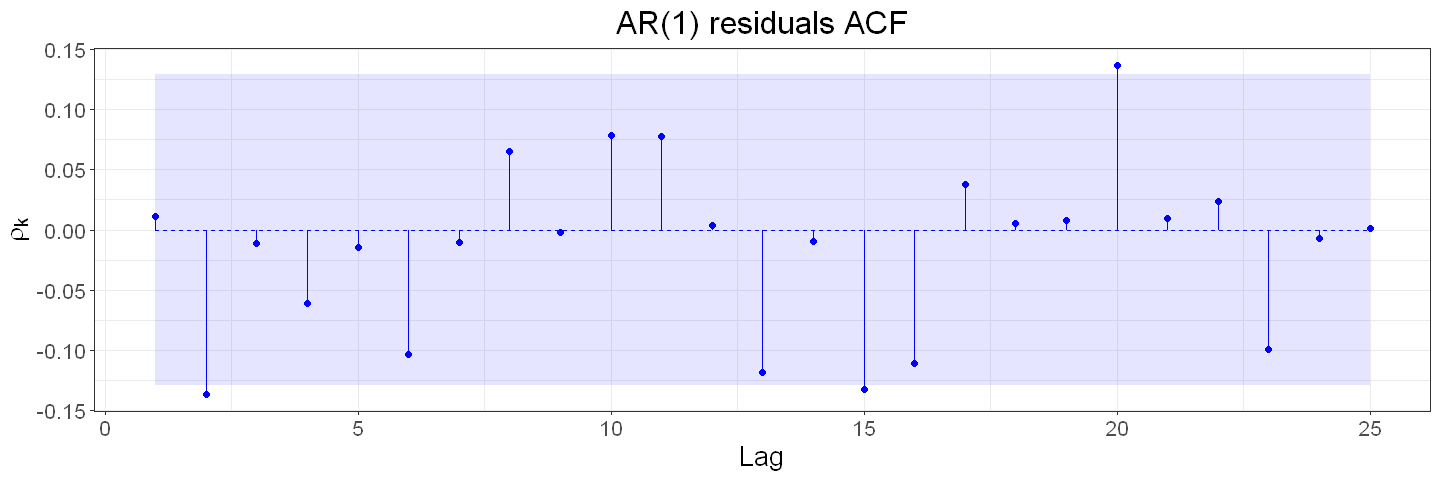

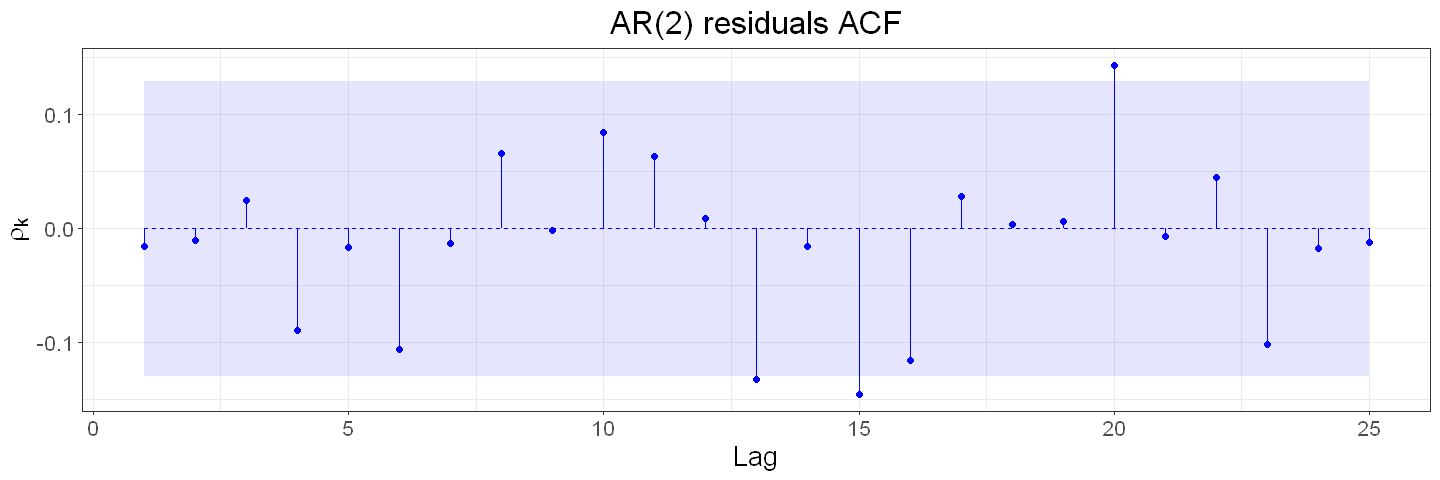

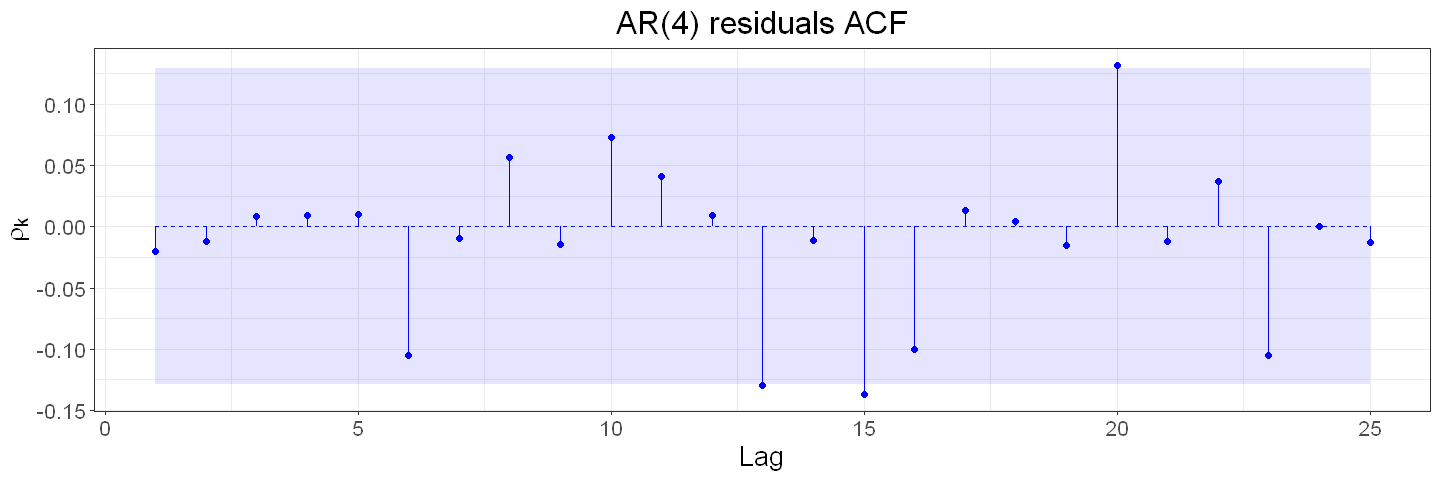

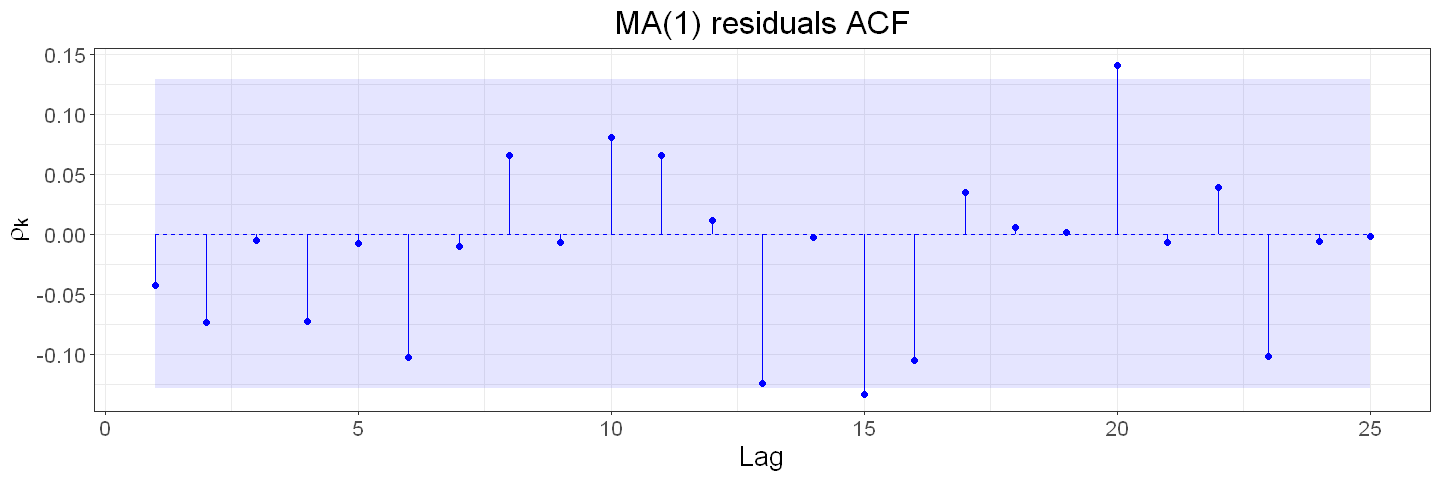

In [8]:
plot_residuals_acf(model.ar1$resid, 'AR(1) residuals ACF', nlags=25)
plot_residuals_acf(model.ar2$resid, 'AR(2) residuals ACF', nlags=25)
plot_residuals_acf(model.ar4$resid, 'AR(4) residuals ACF', nlags=25)
plot_residuals_acf(model.ma1$resid, 'MA(1) residuals ACF', nlags=25)

Residuals for the AR(1) model display significant autocorrelation at lag 2. This is not the issue for all other models. Residuals do appear to present significant autocorrelation at lags 13, 15, and 20 in all models.

In [9]:
ljung.box.test(acf(model.ar1$resid, lag.max=12, plot=F)$acf[-1], n=length(Y), k_ar=1)

$`X-squared`
[1] 12.30751

$df
[1] 11

$`p-value`
[1] 0.3409782

In [10]:
ljung.box.test(acf(model.ar2$resid, lag.max=12, plot=F)$acf[-1], n=length(Y), k_ar=2)

$`X-squared`
[1] 8.829864

$df
[1] 10

$`p-value`
[1] 0.5483228

In [11]:
ljung.box.test(acf(model.ar4$resid, lag.max=12, plot=F)$acf[-1], n=length(Y), k_ar=4)

$`X-squared`
[1] 5.54312

$df
[1] 8

$`p-value`
[1] 0.6982581

In [12]:
ljung.box.test(acf(model.ma1$resid, lag.max=12, plot=F)$acf[-1], n=length(Y), k_ma=1)

$`X-squared`
[1] 9.410844

$df
[1] 11

$`p-value`
[1] 0.5840256

Residuals do not appear to collectively display too much autocorrelation in any of the models.

In [13]:
shapiro.test(model.ar1$resid)


	Shapiro-Wilk normality test

data:  model.ar1$resid
W = 0.96683, p-value = 2.221e-05


In [14]:
shapiro.test(model.ar2$resid)


	Shapiro-Wilk normality test

data:  model.ar2$resid
W = 0.96898, p-value = 4.295e-05


In [15]:
shapiro.test(model.ar4$resid)


	Shapiro-Wilk normality test

data:  model.ar4$resid
W = 0.96983, p-value = 5.597e-05


In [16]:
shapiro.test(model.ma1$resid)


	Shapiro-Wilk normality test

data:  model.ma1$resid
W = 0.96883, p-value = 4.095e-05


Shapiro-Wilk p-value rejects normality on residuals for all models, however -- indicating there are more patterns not captured.

Based on these results, we'd select the MA(1) model for the difference of log prices -- keeping in mind that more modeling may be needed to achieve residual normality.